<a href="https://colab.research.google.com/github/xxziris/protein_ligand_binding/blob/main/code/BS6207_Project_big_matrix_imbalanced_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install sparse

     |████████████████████████████████| 81kB 2.2MB/s 


In [ ]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from sparse import COO
import sparse
import matplotlib.pyplot as plt

## 1. Read Data

- import data from pdb file
- generate negative cases
- train_validation split
- voxelize the training/validation data
- generate train/test dataloader

In [ ]:
# define function to import data from pdb files
def read_pdb(filename):
	
  with open(filename, 'r') as file:
    strline_L = file.readlines()
		# print(strline_L)

  X_list = list()
  Y_list = list()
  Z_list = list()
  atomtype_list = list()
  for strline in strline_L:
		# removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
    stripped_line = strline.strip()

    line_length = len(stripped_line)
		# print("Line length:{}".format(line_length))
    if line_length < 78:
      print("ERROR: line length is different. Expected>=78, current={}".format(line_length))
		
    X_list.append(float(stripped_line[30:38].strip()))
    Y_list.append(float(stripped_line[38:46].strip()))
    Z_list.append(float(stripped_line[46:54].strip()))

    atomtype = stripped_line[76:78].strip()
    if atomtype == 'C':
      atomtype_list.append(1) # 'h' means hydrophobic
    else:
      atomtype_list.append(0) # 'p' means polar

  pdb = np.array([X_list, Y_list, Z_list, atomtype_list])
	
  return pdb


In [ ]:
# read all training filenames
import os

pro_filename = []
lg_filename = []
directory = os.fsencode('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/training_data/')
    
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if '_pro_' in filename: 
       pro_filename.append(os.path.join('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/training_data/', filename))
       continue
     else:
       lg_filename.append(os.path.join('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/training_data/', filename))
       continue

In [ ]:
len(pro_filename)

3000

In [ ]:
len(lg_filename)

3000

In [ ]:
# create the label
def get_label(pro, lig):
  labels = []
  num = min(len(pro), len(lig))
  for i in range(num):
    if pro[i][-15:-11] == lig[i][-15:-11]:
      labels.append(1) # bind
    else:
      labels.append(0) # dont bind
  return labels

In [ ]:
# define a function to generate training/validation set with pos/neg ratio
# function returns two lists of tuples for training/validation set
# each tuple contains the protein filename, ligand filename and the corresponding label
def train_val_split(pro_filename = pro_filename, lg_filename = lg_filename, neg_pos_ratio = 1, val_perc = 0.2, seed = 127):
  # sort the protein and ligand filename list
  lg_filename = sorted(lg_filename)
  pro_filename = sorted(pro_filename)

  # randomly sort the filename to generate negative cases
  random.seed(seed)
  tot_lig_filename = lg_filename.copy()
  tot_pro_filename = pro_filename.copy()
  for i in range(neg_pos_ratio):
    #print(len(lg_filename))
    lg_filename_rand = lg_filename.copy()
    random.shuffle(lg_filename_rand)
    tot_lig_filename += lg_filename_rand
    pro_filename_rand = pro_filename.copy()
    random.shuffle(pro_filename_rand)
    tot_pro_filename += pro_filename_rand
  
  # get labels of the list
  label = get_label(tot_pro_filename, tot_lig_filename)
  print('Total positive cases: ', label.count(0), 'Total negative cases: ', label.count(1))

  # train_validation split
  val_size = round(len(label) * val_perc)
  #print(val_size)
  index = random.sample(range(0,len(label)), val_size) 
  val_lig = [tot_lig_filename[i] for i in index]
  val_pro = [tot_pro_filename[i] for i in index]
  val_label = [label[i] for i in index]
  val_label = np.array(val_label)
  print('Positive cases in validation: ', list(val_label).count(0), 
        'Negative cases in validation: ', list(val_label).count(1))

  # the rest will be training set
  train_index = list(set(range(len(label))) - set(index))
  train_lig = [tot_lig_filename[i] for i in train_index]
  train_pro = [tot_pro_filename[i] for i in train_index]
  train_label = [label[i] for i in train_index]
  train_label = np.array(train_label)
  print('Positive cases in training: ', list(train_label).count(0), 
        'Negatvie cases in training: ', list(train_label).count(1))
  
  # shuffle the validation set sequence
  all_val = []
  for i in range(len(val_label)):
    all_val.append((val_pro[i], val_lig[i], val_label[i]))
  all_val = random.sample(all_val, k = len(all_val))

  # shuffle the training  set sequence
  all_train = []
  for i in range(len(train_label)):
    all_train.append((train_pro[i], train_lig[i], train_label[i]))
  all_train[:5]
  all_train = random.sample(all_train, k = len(all_train))

  return all_train, all_val

In [ ]:
# define function for voxelization
def voxelize(pro_filename, lig_filename, max_side = 30, grid = 4):
  # import the pdb file as array
  pro = read_pdb(pro_filename).astype(np.float32)
  lig = read_pdb(lig_filename).astype(np.float32)

  # calculate box_size
  box_size = np.ceil(2 * max_side / grid + 1)

  # get the centroid of the ligand/protein
  lig_cent = np.mean(lig[:3, :], axis = 1, keepdims = True)  
  pro_cent = np.mean(pro[:3, :], axis = 1, keepdims = True)

  # shift the protein by the centroid of ligand at 0
  for i in range(3):
    lig[i] = lig[i] - lig_cent[i]
    pro[i] = pro[i] - lig_cent[i]
  
  # combine the coordinate and atom type of protein and ligand
  all_coord = np.c_[pro[:3], lig[:3]]
  lig[3] = np.where(lig[3] == 0, 100, 200)
  all_atom = np.r_[pro[3], lig[3]]

  # round coordinate to the nearest grid point
  all_coord = (all_coord + max_side) / grid
  
  # remove atoms outside the box
  check = ((all_coord>0) & (all_coord < box_size)).all(axis = 0)
  all_coord = all_coord[:,check]
  all_atom = all_atom[check]

  # round the coordinates to integer
  all_coord = (all_coord).astype(int)

  # create the sparse matrix
  s = sparse.COO(all_coord, all_atom, shape = (int(box_size), int(box_size), int(box_size)))  
  return s

In [ ]:
# define function to build dataloader for the neural network
# function returns the dataloader for both train and validation
def dataloader_builder(all_train, all_val, batch_size = 128, max_side = 30, grid = 4):
  # load the training sparse 3d matrix
  print(max_side, grid)
  train_cube = []
  for i in range(len(all_train)):
    temp = voxelize(all_train[i][0], all_train[i][1], max_side, grid)
    train_cube.append(COO.todense(temp))
  train_cube = np.array(train_cube)
  train_cube = train_cube.reshape(train_cube.shape[0], 1, train_cube.shape[1], train_cube.shape[2], train_cube.shape[3])
  print(train_cube.shape)
  print(np.ceil(2 * max_side / grid + 1))

  # build the train dataloader
  train_data = []
  for i in range(len(all_train)):
    train_data.append([train_cube[i], all_train[i][2]])
  trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = batch_size) 

  # load the validation sparse 3d matrix
  val_cube = []
  for i in range(len(all_val)):
    temp = voxelize(all_val[i][0], all_val[i][1], max_side, grid)
    val_cube.append(COO.todense(temp))
  val_cube = np.array(val_cube)
  val_cube = val_cube.reshape(val_cube.shape[0], 1, val_cube.shape[1], val_cube.shape[2], val_cube.shape[3])
  print(val_cube.shape)

  # build the validation dataloader
  val_data = []
  for i in range(len(all_val)):
    val_data.append([val_cube[i], all_val[i][2]])
  valloader = torch.utils.data.DataLoader(val_data, shuffle = True, batch_size = batch_size)

  return trainloader, valloader

In [ ]:
np.ceil(2 * 24 /2 + 1)

25.0

In [ ]:
# define function to plot confusion matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [ ]:
# define function to reset model weight
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

In [ ]:
# define function to calculate accuracy
def accuracy(outputs, labels):
    #preds = torch.round(outputs)
    y_pred_softmax = torch.softmax(outputs, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    #preds = torch.argmax(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
# define a function to DYNAMICALLY generate training/validation set with pos/neg ratio
# function returns two lists of tuples for training/validation set
# each tuple contains the protein filename, ligand filename and the corresponding label
def dynamic_train_val_split(pro_filename = pro_filename, lg_filename = lg_filename, neg_pos_ratio = 1, val_perc = 0.2, seed = 127):
  # sort the protein and ligand filename list
  lg_filename = sorted(lg_filename)
  pro_filename = sorted(pro_filename)

  val_size = round(len(pro_filename) * val_perc)

  # select the first val_size pairs as positive validation
  val_lg_pos = lg_filename[:val_size]
  val_pro_pos = pro_filename[:val_size]

  # generate val_size negative validation
  random.seed(seed)
  val_lg_neg = val_lg_pos.copy()
  random.shuffle(val_lg_neg)
  val_pro_neg = val_pro_pos.copy()
  random.shuffle(val_pro_neg)

  val_lg = val_lg_pos + val_lg_neg
  val_pro = val_pro_pos + val_pro_neg

  # use the rest for training
  train_lg_pos = lg_filename[val_size:]
  train_pro_pos = pro_filename[val_size:]

  # randomly sort the filename to generate negative cases
  random.seed(seed)
  tot_lig_filename = train_lg_pos.copy()
  tot_pro_filename = train_pro_pos.copy()
  for i in range(neg_pos_ratio):
    #print(len(lg_filename))
    lg_filename_rand = train_lg_pos.copy()
    random.shuffle(lg_filename_rand)
    tot_lig_filename += lg_filename_rand
    pro_filename_rand = train_pro_pos.copy()
    random.shuffle(pro_filename_rand)
    tot_pro_filename += pro_filename_rand
  
  # get labels of the list for training
  label_train = get_label(tot_pro_filename, tot_lig_filename)
  print('Positive cases in training: ', label_train.count(0), 'Negative cases in training: ', label_train.count(1))
  label_val = get_label(val_pro, val_lg)
  print('Positive cases in val: ', label_val.count(0), 'Negative cases in training: ', label_val.count(1))
  
  # shuffle the validation set sequence
  all_val = []
  for i in range(len(label_val)):
    all_val.append((val_pro[i], val_lg[i], label_val[i]))
  all_val = random.sample(all_val, k = len(all_val))

  # shuffle the training  set sequence
  all_train = []
  for i in range(len(label_train)):
    all_train.append((tot_pro_filename[i], tot_lig_filename[i], label_train[i]))
  all_train[:5]
  all_train = random.sample(all_train, k = len(all_train))

  return all_train, all_val

## Build the neural network

In [ ]:
 # trial 1 - CNN
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.cnn_layers = nn.Sequential(
        nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=0),
        nn.BatchNorm3d(8),
        nn.ReLU(inplace=True),
        nn.MaxPool3d(kernel_size=2, stride=1),
        # Defining another 2D convolution layer
        nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=0),
        nn.BatchNorm3d(16),
        nn.ReLU(inplace=True),
        nn.MaxPool3d(kernel_size=2, stride=2),
        # Defining another 2D convolution layer
        nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=0),
        nn.BatchNorm3d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool3d(kernel_size=2, stride=2),
    )

    self.linear_layers = nn.Sequential(
            nn.Dropout(p = 0.1),
            nn.Linear(32 * 4 * 4 * 4 , 32),
            nn.ReLU(),
            nn.Linear(32,2)
        )

  def forward(self, x):
    x = self.cnn_layers(x)
    x = torch.flatten(x, start_dim = 1)
    x = self.linear_layers(x)
    return x

In [ ]:
from torch.optim import Adam
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0005) # weight_decay = 0.005
# defining the loss function
weight = torch.tensor([1.0, 100.])
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (9): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=2048, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_

In [ ]:
# number of parameters in the model
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

83298

In [ ]:
# define each epoch when training
def train(epoch, trainloader, valloader):
  train.train_loss = 0
  train.train_acces = 0
  model.train()
  total = 0
  correct = 0
  for images, labels in trainloader:
    #print(images.shape, labels.shape)
    optimizer.zero_grad() # clear the gradient
    output_train = model(images)   # calculate model output 
    #loss_train = criterion(output_train.squeeze(), labels) # calculate loss
    loss_train = criterion(output_train, labels)
        
    loss_train.backward()   # back propagation
    optimizer.step() # update model weights
        
    train.train_loss += loss_train.item() * images.size(0)
    acc = accuracy(output_train, labels)
    train.train_acces += acc
    

  print("Epoch {} - Training loss: {}, Training Accuracy: {}".format(epoch+1, train.train_loss / len(trainloader), train.train_acces / len(trainloader)))
  model.eval() 
  with torch.no_grad():
    train.val_acces = 0
    train.val_loss = 0
    for images, labels in valloader:
      output_val = model(images)
      #loss_val = criterion(output_val.squeeze(), labels)
      loss_val = criterion(output_val, labels)

      train.val_loss += loss_val.item() * images.size(0)
      #val_acc = accuracy_quick(output_train, labels)
      #val_acces += val_acc.item()     
      acc = accuracy(output_val, labels)   
      train.val_acces += acc
  
  print("Validation loss: {}, Validation Accuracy: {}".format(train.val_loss / len(valloader), train.val_acces / len(valloader)))


In [ ]:
model.apply(weight_reset)

Net(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (9): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=2048, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_

## Define Cost-sensitive loss function

Cost Sensitive loss function

https://arxiv.org/pdf/2010.00291.pdf

https://github.com/agaldran/cost_sensitive_loss_classification/blob/master/CS_loss.ipynb

In [ ]:
import torch.nn.functional as F
import scipy.stats as stats2
import sys
try:
    from kornia.losses import FocalLoss as focal_loss
except:
    pass

def get_gauss_label(label, n_classes, amplifier, noise=0):
    n = n_classes*amplifier
    half_int = amplifier/2
    label_noise = np.random.uniform(low=-noise, high=noise)
    if label == 0:
        label_noise = np.abs(label_noise)
    if label == 4:
        label_noise = -np.abs(label_noise)
    label += label_noise
    label_new = half_int + label*amplifier
    gauss_label = stats2.norm.pdf(np.arange(n), label_new, half_int/2)
    gauss_label/=np.sum(gauss_label)
    return gauss_label

def get_gaussian_label_distribution(n_classes, std=0.5):
    cls = []
    for n in range(n_classes):
        cls.append(stats2.norm.pdf(range(n_classes), 0, std))
    dists = np.stack(cls, axis=0)
    return dists

def cross_entropy_loss_one_hot(logits, target, reduction='mean'):
    logp = F.log_softmax(logits, dim=1)
    loss = torch.sum(-logp * target, dim=1)
    if reduction == 'none':
        return loss
    elif reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        raise ValueError(
            '`reduction` must be one of \'none\', \'mean\', or \'sum\'.')

def one_hot_encoding(label, n_classes):
    return torch.zeros(label.size(0), n_classes).to(label.device).scatter_(
        1, label.view(-1, 1), 1)

def label_smoothing_criterion(alpha=0.1, distribution='uniform', std=0.5, reduction='mean'):
    def _label_smoothing_criterion(logits, labels):
        n_classes = logits.size(1)
        device = logits.device
        # manipulate labels
        one_hot = one_hot_encoding(labels, n_classes).float().to(device)
        if distribution == 'uniform':
            uniform = torch.ones_like(one_hot).to(device)/n_classes
            soft_labels = (1 - alpha)*one_hot + alpha*uniform
        elif distribution == 'gaussian':
            dist = get_gaussian_label_distribution(n_classes, std=std)
            soft_labels = torch.from_numpy(dist[labels.cpu().numpy()]).to(device)
        else:
            raise NotImplementedError

        loss = cross_entropy_loss_one_hot(logits, soft_labels.float(), reduction)

        return loss

    return _label_smoothing_criterion

def cost_sensitive_loss(input, target, M):
    if input.size(0) != target.size(0):
        raise ValueError('Expected input batch_size ({}) to match target batch_size ({}).'
                         .format(input.size(0), target.size(0)))
    device = input.device
    M = M.to(device)
    return (M[target, :]*input.float()).sum(axis=-1)
    # return torch.diag(torch.matmul(input, M[:, target]))

class CostSensitiveLoss(nn.Module):
    def __init__(self,  n_classes, exp=1, normalization='softmax', reduction='mean'):
        super(CostSensitiveLoss, self).__init__()
        if normalization == 'softmax':
            self.normalization = nn.Softmax(dim=1)
        elif normalization == 'sigmoid':
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = None
        self.reduction = reduction
        x = np.abs(np.arange(n_classes, dtype=np.float32))
        M = np.abs((x[:, np.newaxis] - x[np.newaxis, :])) ** exp
        M /= M.max()
        self.M = torch.from_numpy(M)

    def forward(self, logits, target):
        preds = self.normalization(logits)
        loss = cost_sensitive_loss(preds, target, self.M)
        if self.reduction == 'none':
            return loss
        elif self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            raise ValueError('`reduction` must be one of \'none\', \'mean\', or \'sum\'.')

class CostSensitiveRegularizedLoss(nn.Module):
    def __init__(self,  n_classes=5, exp=2, normalization='softmax', reduction='mean', base_loss='ce', lambd=10):
        super(CostSensitiveRegularizedLoss, self).__init__()
        if normalization == 'softmax':
            self.normalization = nn.Softmax(dim=1)
        elif normalization == 'sigmoid':
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = None
        self.reduction = reduction
        x = np.abs(np.arange(n_classes, dtype=np.float32))
        M = np.abs((x[:, np.newaxis] - x[np.newaxis, :])) ** exp
        #
        # M_oph = np.array([
        #                 [1469, 4, 5,  0,  0],
        #                 [58, 62,  5,  0,  0],
        #                 [22, 3, 118,  1,  0],
        #                 [0, 0,   13, 36,  1],
        #                 [0, 0,    0,  1, 15]
        #                 ], dtype=np.float)
        # M_oph = M_oph.T
        # # Normalize M_oph to obtain M_difficulty:
        # M_difficulty = 1-np.divide(M_oph, np.sum(M_oph, axis=1)[:, None])
        # # OPTION 1: average M and M_difficulty:
        # M = 0.5 * M + 0.5 * M_difficulty
        # ################
        # # OPTION 2: replace uninformative entries in M_difficulty by entries of M:
        # # M_difficulty[M_oph == 0] = M[M_oph == 0]
        # # M = M_difficulty

        M /= M.max()
        self.M = torch.from_numpy(M)
        self.lambd = lambd
        self.base_loss = base_loss

        if self.base_loss == 'ce':
            self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        elif self.base_loss == 'ls':
            self.base_loss = label_smoothing_criterion(distribution='uniform', reduction=reduction)
        elif self.base_loss == 'gls':
            self.base_loss = label_smoothing_criterion(distribution='gaussian', reduction=reduction)
        elif self.base_loss == 'focal_loss':
            kwargs = {"alpha": 0.5, "gamma": 2.0, "reduction": reduction}
            self.base_loss = focal_loss(**kwargs)
        else:
            sys.exit('not a supported base_loss')

    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        if self.lambd == 0:
            return self.base_loss(logits, target)
        else:
            preds = self.normalization(logits)
            loss = cost_sensitive_loss(preds, target, self.M)
            if self.reduction == 'none':
                return base_l + self.lambd*loss
            elif self.reduction == 'mean':
                return base_l + self.lambd*loss.mean()
            elif self.reduction == 'sum':
                return base_l + self.lambd*loss.sum()
            else:
                raise ValueError('`reduction` must be one of \'none\', \'mean\', or \'sum\'.')

def get_cost_sensitive_criterion(n_classes=5, exp=2):
    train_criterion = CostSensitiveLoss(n_classes, exp=exp, normalization='softmax')
    val_criterion = CostSensitiveLoss(n_classes, exp=exp, normalization='softmax')
    return train_criterion, val_criterion

def get_cost_sensitive_regularized_criterion(base_loss='ce', n_classes=5, lambd=1, exp=2):
    train_criterion = CostSensitiveRegularizedLoss(n_classes, exp=exp, normalization='softmax', base_loss=base_loss, lambd=lambd)
    val_criterion = CostSensitiveRegularizedLoss(n_classes, exp=exp, normalization='softmax', base_loss=base_loss, lambd=lambd)

    return train_criterion, val_criterion


### Trial 1 - Cost-sensitive lost function (10:400:200:0) + dynamic training data refreshed every 5 epochs


In [ ]:
#from torch.optim import Adam
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0005) # weight_decay = 0.005

# defining the loss function
n_classes = 2
base_loss = 'ce'
lambd = 10 # regularization parameter
criterion = CostSensitiveRegularizedLoss(n_classes = n_classes, base_loss = base_loss, lambd = lambd)
M = np.array([[10, 400], [200, 0]], dtype = float)
M /= M.max()
criterion.M = torch.from_numpy(M)

M

array([[0.025, 1.   ],
       [0.5  , 0.   ]])

In [ ]:
model.apply(weight_reset)

Net(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (9): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=2048, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_

In [ ]:
# defining the number of epochs
n_epochs = 50
# empty list to store training losses
train_losses4 = []
train_acc4 = []
# empty list to store validation losses
val_losses4 = []
val_acc4 =[]
epoch_count4 = []
# training the model
es = 0
best_loss = 1000
for epoch in range(n_epochs):
    if epoch % 5 != 0:
      pass
    else:
      all_train, all_val = dynamic_train_val_split(val_perc = 0.15, seed = epoch)
      trainloader, valloader = dataloader_builder(all_train, all_val, max_side = 24, grid = 2)

    train(epoch, trainloader = trainloader, valloader = valloader)
    epoch_count4.append(epoch)
    train_losses4.append(train.train_loss/len(trainloader))
    val_losses4.append(train.val_loss/len(valloader))
    train_acc4.append(train.train_acces/len(trainloader))
    val_acc4.append(train.val_acces/len(valloader))
    # early stopping
    if train.val_loss/len(valloader) < best_loss:
      best_loss = train.val_loss/len(valloader)
      es = 0
      torch.save(model.state_dict(), "model_" + str(epoch) + 'weight_trial4.pt')
      best_epoch = epoch
    else:
      es += 1
      print("Counter {} of 15".format(es))

    if es > 14:
      print("Early stopping! Best epoch: ", str(best_epoch))
      model.load_state_dict(torch.load('/content/model_' + str(best_epoch) +'weight_trial4.pt'))
      break

Positive cases in training:  2548 Negative cases in training:  2552
Positive cases in val:  450 Negative cases in training:  450
24 2
(5100, 1, 25, 25, 25)
25.0
(900, 1, 25, 25, 25)
Epoch 1 - Training loss: 521.5084719199688, Training Accuracy: 0.5004629492759705
Validation loss: 446.78596654254943, Validation Accuracy: 0.439453125
Epoch 2 - Training loss: 423.8787588523577, Training Accuracy: 0.5899884104728699
Validation loss: 196.8905273090495, Validation Accuracy: 0.8994140625
Epoch 3 - Training loss: 157.1382585258529, Training Accuracy: 0.9049116969108582
Validation loss: 109.8295260975068, Validation Accuracy: 0.896484375
Epoch 4 - Training loss: 130.59828230266058, Training Accuracy: 0.926982045173645
Validation loss: 86.33050739211751, Validation Accuracy: 0.9580078125
Epoch 5 - Training loss: 124.79233334012754, Training Accuracy: 0.9311921000480652
Validation loss: 94.63131210190272, Validation Accuracy: 0.955078125
Counter 1 of 15
Positive cases in training:  2548 Negative 

Text(0, 0.5, 'loss')

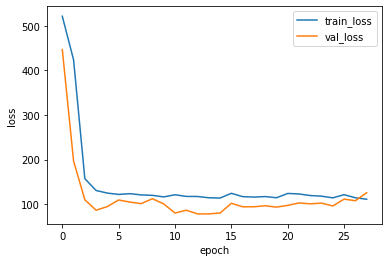

In [ ]:
plt.plot(epoch_count4, train_losses4, label = 'train_loss')
plt.plot(epoch_count4, val_losses4, label = 'val_loss')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

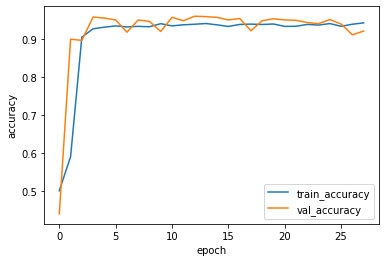

In [ ]:
plt.plot(epoch_count4, train_acc4, label = 'train_accuracy')
plt.plot(epoch_count4, val_acc4, label = 'val_accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('accuracy')

In [ ]:
# model.load_state_dict(torch.load('//content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/model_22weight_trial4_bigmatrix.pt'))

<All keys matched successfully>

Normalized confusion matrix
[[0.89555556 0.10444444]
 [0.02888889 0.97111111]]


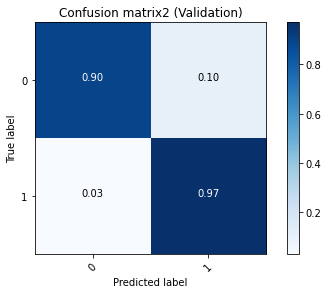

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valloader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')

Normalized confusion matrix
[[0.91137255 0.08862745]
 [0.02980392 0.97019608]]


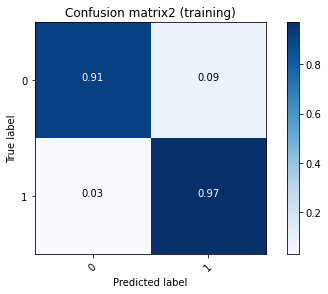

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in trainloader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (training)')

In [ ]:
# load the validation sparse 3d matrix
valtest_cube = []
for i in range(len(all_val)):
  temp = voxelize(all_val[i][0], all_val[i][1], max_side = 24, grid = 2)
  valtest_cube.append(COO.todense(temp))
valtest_cube = np.array(valtest_cube)
valtest_cube = valtest_cube.reshape(valtest_cube.shape[0], 1, valtest_cube.shape[1], valtest_cube.shape[2], valtest_cube.shape[3])
print(valtest_cube.shape)

# build the validation dataloader
valtest_data = []
count = 0
for i in range(len(all_val)):
  if all_val[i][2] == 0:
    #print(0)
    pass
  elif (all_val[i][2] == 1) & (count < 45):
    count += 1
    pass
  else:
    continue
  valtest_data.append([valtest_cube[i], all_val[i][2]])
valtest_loader = torch.utils.data.DataLoader(valtest_data, shuffle = True)

(900, 1, 25, 25, 25)


Normalized confusion matrix
[[0.89555556 0.10444444]
 [0.         1.        ]]


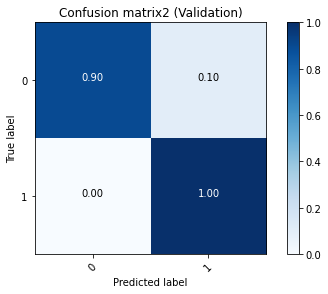

In [ ]:
model.load_state_dict(torch.load('/content/model_12weight_trial4.pt'))
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valtest_loader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')

In [ ]:
# check the model performance in validation set by predicting the top 10 binding ligand
model.load_state_dict(torch.load('/content/model_12weight_trial4.pt'))
# sort the protein and ligand filename list
lg_filename = sorted(lg_filename)
pro_filename = sorted(pro_filename)

# select the first val_size pairs as positive validation
val_lg_pos = lg_filename[:100]
val_pro_pos = pro_filename[0:30]

model.eval()
val_pro = []
val_lig = []
val_bind_score = []
val_notbind_score = []
for i in range(30):
  for j in range(100):
    val_pro.append(i+1)
    val_lig.append(j+1)
    temp = voxelize(pro_filename=val_pro_pos[i], lig_filename=val_lg_pos[j], max_side=24, grid=2)
    temp = torch.from_numpy(COO.todense(temp))
    temp = torch.reshape(temp, (1,1,25,25,25))
    output = model(temp)
    output = torch.softmax(output, dim = 1)
    output = output.detach().numpy()
    #print(output)
    val_bind_score.append(output[0][1])
    val_notbind_score.append(output[0][0])

val_df = pd.DataFrame({'pro': val_pro, 'lig': val_lig, 'bind_prob': val_bind_score, 'notbind_prob': val_notbind_score})
val_df = val_df[val_df.bind_prob > val_df.notbind_prob]
val_df_top = pd.DataFrame(val_df.groupby(['pro'])['bind_prob'].nlargest(10)).reset_index()


In [ ]:
temp = list(val_df.lig.loc[val_df_top.level_1])
val_df_top['lig_id'] = temp
val_df_top.head()

,pro,level_1,bind_prob,lig_id
0,1,48,0.997197,49
1,1,96,0.995971,97
2,1,84,0.989319,85
3,1,0,0.987288,1
4,1,39,0.983373,40


In [ ]:
for i in range(30):
  print(i+1)
  print(val_df_top.lig_id[val_df_top.pro == i+1]) # able to predict most of the  binding pairs within the top 10 ligand (26/30)

1
0    49
1    97
2    85
3     1
4    40
5    80
6    66
7    82
8    76
9    69
Name: lig_id, dtype: int64
2
10    34
11    19
12     2
13     6
Name: lig_id, dtype: int64
3
14    82
15     5
16    18
17    58
18    32
19    89
20    45
21    97
22    59
23     3
Name: lig_id, dtype: int64
4
24     4
25    29
26    90
Name: lig_id, dtype: int64
5
27    89
28    79
29    53
30    58
31     5
32    59
33    15
34     3
35    50
36    97
Name: lig_id, dtype: int64
6
37    52
38     6
39    93
40    60
41    58
42    20
43     3
44    23
45    71
46    73
Name: lig_id, dtype: int64
7
47     7
48    43
49    44
Name: lig_id, dtype: int64
8
50    78
51     8
52    86
Name: lig_id, dtype: int64
9
53    40
54    66
55     9
56    97
Name: lig_id, dtype: int64
10
57    75
58    47
59    10
60    94
Name: lig_id, dtype: int64
11
61    11
62    87
Name: lig_id, dtype: int64
12
63    12
64    98
65    54
66    64
67    67
Name: lig_id, dtype: int64
13
68    44
69    31
70    95
71    43
72    13

### Trail 2 - Cost-sensitive loss function (10:800:400:0) + dynamic training data refreshed every 5 epochs

In [ ]:
#from torch.optim import Adam
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0005) # weight_decay = 0.005

# defining the loss function
n_classes = 2
base_loss = 'ce'
lambd = 10 # regularization parameter
criterion = CostSensitiveRegularizedLoss(n_classes = n_classes, base_loss = base_loss, lambd = lambd)
#M = np.array([[10, 400], [200, 0]], dtype = float)
M = np.array([[10,800], [400, 0]], dtype = float)
M /= M.max()
criterion.M = torch.from_numpy(M)

M

array([[0.0125, 1.    ],
       [0.5   , 0.    ]])

In [ ]:
model.apply(weight_reset)

Net(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (9): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=2048, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_

In [ ]:
# defining the number of epochs
n_epochs = 80
# empty list to store training losses
train_losses5 = []
train_acc5 = []
# empty list to store validation losses
val_losses5 = []
val_acc5 =[]
epoch_count5 = []
# training the model
es = 0
best_loss = 1000
for epoch in range(n_epochs):
    if epoch % 5 != 0:
      pass
    else:
      all_train, all_val = dynamic_train_val_split(val_perc = 0.15, seed = epoch)
      trainloader, valloader = dataloader_builder(all_train, all_val, max_side = 24, grid = 2)

    train(epoch, trainloader = trainloader, valloader = valloader)
    epoch_count5.append(epoch)
    train_losses5.append(train.train_loss/len(trainloader))
    val_losses5.append(train.val_loss/len(valloader))
    train_acc5.append(train.train_acces/len(trainloader))
    val_acc5.append(train.val_acces/len(valloader))
    # early stopping
    if train.val_loss/len(valloader) < best_loss:
      best_loss = train.val_loss/len(valloader)
      es = 0
      torch.save(model.state_dict(), "model_" + str(epoch) + 'weight_trial5.pt')
      best_epoch = epoch
    else:
      es += 1
      print("Counter {} of 15".format(es))

    if es > 14:
      print("Early stopping! Best epoch: ", str(best_epoch))
      model.load_state_dict(torch.load('/content/model_' + str(best_epoch) +'weight_trial5.pt'))
      break

Positive cases in training:  2548 Negative cases in training:  2552
Positive cases in val:  450 Negative cases in training:  450
24 2
(5100, 1, 25, 25, 25)
25.0
(900, 1, 25, 25, 25)
Epoch 1 - Training loss: 507.2353044210933, Training Accuracy: 0.5020543932914734
Validation loss: 428.2422364167869, Validation Accuracy: 0.5302734375
Epoch 2 - Training loss: 309.673734375328, Training Accuracy: 0.7167389988899231
Validation loss: 318.3041671396334, Validation Accuracy: 0.607421875
Epoch 3 - Training loss: 123.98900942398446, Training Accuracy: 0.9253689050674438
Validation loss: 76.60289321749062, Validation Accuracy: 0.9619140625
Epoch 4 - Training loss: 120.23942807402682, Training Accuracy: 0.9301432371139526
Validation loss: 75.48079034303369, Validation Accuracy: 0.9296875
Epoch 5 - Training loss: 117.57592774164698, Training Accuracy: 0.9313513040542603
Validation loss: 74.90017928289814, Validation Accuracy: 0.9599609375
Positive cases in training:  2548 Negative cases in training

Text(0, 0.5, 'loss')

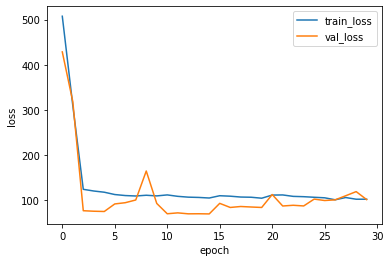

In [ ]:
plt.plot(epoch_count5, train_losses5, label = 'train_loss')
plt.plot(epoch_count5, val_losses5, label = 'val_loss')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

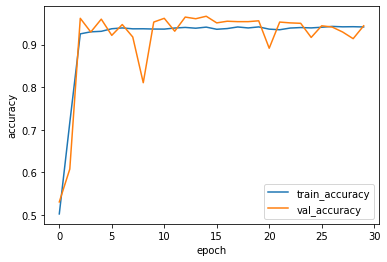

In [ ]:
plt.plot(epoch_count5, train_acc5, label = 'train_accuracy')
plt.plot(epoch_count5, val_acc5, label = 'val_accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('accuracy')

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/model_49weight_trial5_800.pt'))

<All keys matched successfully>

Normalized confusion matrix
[[0.87777778 0.12222222]
 [0.00666667 0.99333333]]


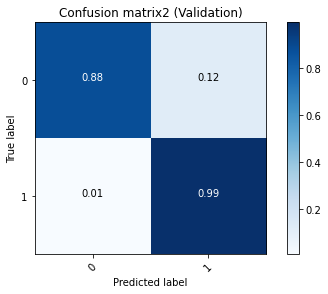

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valloader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')

Normalized confusion matrix
[[0.89411765 0.10588235]
 [0.01686275 0.98313725]]


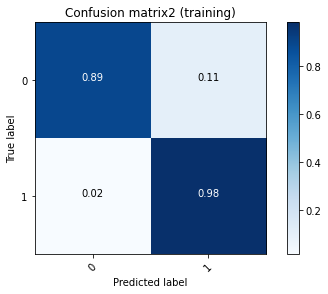

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in trainloader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (training)')

Normalized confusion matrix
[[0.87777778 0.12222222]
 [0.         1.        ]]


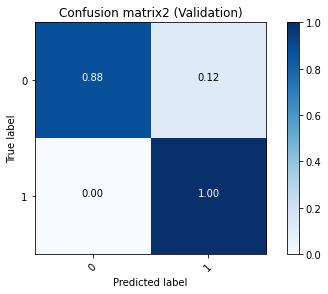

In [ ]:
model.load_state_dict(torch.load('/content/model_14weight_trial5.pt'))
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valtest_loader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')

### Trail 3 - Cost-sensitive loss function (5:100:50:0) + dynamic training data refresh every 5 epochs

In [ ]:
#from torch.optim import Adam
# defining the model
model = Net()
# defining the optimizer
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=0.0005) # weight_decay = 0.005

# defining the loss function
n_classes = 2
base_loss = 'ce'
lambd = 10 # regularization parameter
criterion = CostSensitiveRegularizedLoss(n_classes = n_classes, base_loss = base_loss, lambd = lambd)
#M = np.array([[10, 400], [200, 0]], dtype = float)
M = np.array([[5,100], [50, 0]], dtype = float)
M /= M.max()
criterion.M = torch.from_numpy(M)

M

array([[0.05, 1.  ],
       [0.5 , 0.  ]])

In [ ]:
model.apply(weight_reset)

Net(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (9): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=2048, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_

In [ ]:
# defining the number of epochs
n_epochs = 80
# empty list to store training losses
train_losses6 = []
train_acc6 = []
# empty list to store validation losses
val_losses6 = []
val_acc6 =[]
epoch_count6 = []
# training the model
es = 0
best_loss = 1000
for epoch in range(n_epochs):
    if epoch % 5 != 0:
      pass
    else:
      all_train, all_val = dynamic_train_val_split(val_perc = 0.15, seed = epoch)
      trainloader, valloader = dataloader_builder(all_train, all_val, max_side = 24, grid = 2)

    train(epoch, trainloader = trainloader, valloader = valloader)
    epoch_count6.append(epoch)
    train_losses6.append(train.train_loss/len(trainloader))
    val_losses6.append(train.val_loss/len(valloader))
    train_acc6.append(train.train_acces/len(trainloader))
    val_acc6.append(train.val_acces/len(valloader))
    # early stopping
    if train.val_loss/len(valloader) < best_loss:
      best_loss = train.val_loss/len(valloader)
      es = 0
      torch.save(model.state_dict(), "model_" + str(epoch) + 'weight_trial6.pt')
      best_epoch = epoch
    else:
      es += 1
      print("Counter {} of 15".format(es))

    if es > 14:
      print("Early stopping! Best epoch: ", str(best_epoch))
      model.load_state_dict(torch.load('/content/model_' + str(best_epoch) +'weight_trial6.pt'))
      break

Positive cases in training:  2548 Negative cases in training:  2552
Positive cases in val:  450 Negative cases in training:  450
24 2
(5100, 1, 25, 25, 25)
25.0
(900, 1, 25, 25, 25)
Epoch 1 - Training loss: 534.5732578694821, Training Accuracy: 0.4972800612449646
Validation loss: 463.79240281600505, Validation Accuracy: 0.5
Epoch 2 - Training loss: 494.54676494449376, Training Accuracy: 0.5023292899131775
Validation loss: 407.53719829395413, Validation Accuracy: 0.5
Epoch 3 - Training loss: 224.31902636756567, Training Accuracy: 0.8808014988899231
Validation loss: 172.19853158873775, Validation Accuracy: 0.859375
Epoch 4 - Training loss: 146.8096570784999, Training Accuracy: 0.9276041984558105
Validation loss: 97.96885445081148, Validation Accuracy: 0.9580078125
Epoch 5 - Training loss: 140.52699218078078, Training Accuracy: 0.932754635810852
Validation loss: 97.1396555973763, Validation Accuracy: 0.9296875
Positive cases in training:  2548 Negative cases in training:  2552
Positive ca

Text(0, 0.5, 'loss')

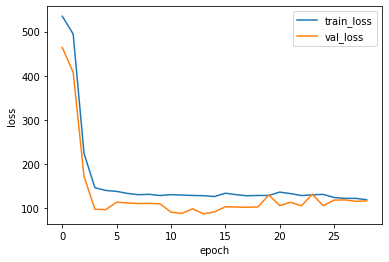

In [ ]:
plt.plot(epoch_count6, train_losses6, label = 'train_loss')
plt.plot(epoch_count6, val_losses6, label = 'val_loss')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

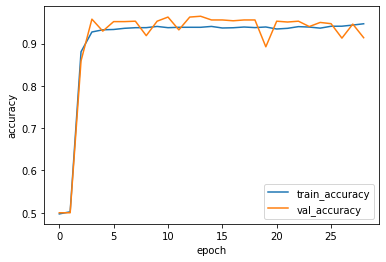

In [ ]:
plt.plot(epoch_count6, train_acc6, label = 'train_accuracy')
plt.plot(epoch_count6, val_acc6, label = 'val_accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('accuracy')

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/model_14weight_trial6_lostfunction_100.pt'))

<All keys matched successfully>

Normalized confusion matrix
[[0.89111111 0.10888889]
 [0.01777778 0.98222222]]


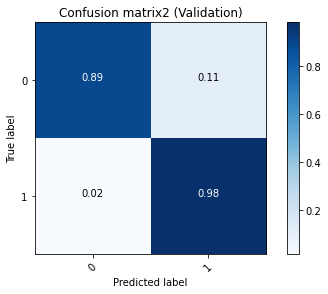

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valloader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix( y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')

Normalized confusion matrix
[[0.89960784 0.10039216]
 [0.0227451  0.9772549 ]]


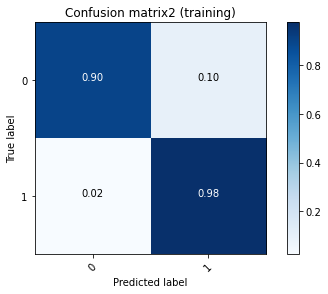

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in trainloader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (training)')

In [ ]:
# load the validation sparse 3d matrix
valtest_cube = []
for i in range(len(all_val)):
  temp = voxelize(all_val[i][0], all_val[i][1], max_side = 24, grid = 2)
  valtest_cube.append(COO.todense(temp))
valtest_cube = np.array(valtest_cube)
valtest_cube = valtest_cube.reshape(valtest_cube.shape[0], 1, valtest_cube.shape[1], valtest_cube.shape[2], valtest_cube.shape[3])
print(valtest_cube.shape)

# build the validation dataloader
valtest_data = []
count = 0
for i in range(len(all_val)):
  if (all_val[i][2] == 0):
    #print(0)
    pass
  elif (all_val[i][2] == 1) & (count < 45):
    count += 1
    pass
  else:
    continue
  valtest_data.append([valtest_cube[i], all_val[i][2]])
valtest_loader = torch.utils.data.DataLoader(valtest_data, shuffle = True)

(900, 1, 25, 25, 25)


Normalized confusion matrix
[[0.89111111 0.10888889]
 [0.02222222 0.97777778]]


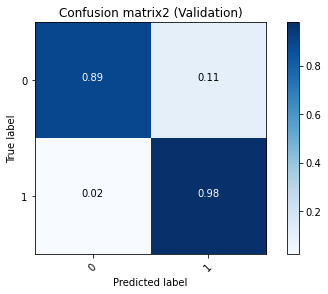

In [ ]:
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valtest_loader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')

In [ ]:
torch.max(torch.tensor([[-0.01, -5.0]]), dim = 1)

torch.return_types.max(values=tensor([-0.0100]), indices=tensor([0]))

### Trail 4 - normal cross entropy + dynamic training data refresh every 5 epochs

In [ ]:
#from torch.optim import Adam
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0005) # weight_decay = 0.005

criterion = nn.CrossEntropyLoss()

In [ ]:
model.apply(weight_reset)

Net(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (9): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=2048, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_

In [ ]:
# defining the number of epochs
n_epochs = 80
# empty list to store training losses
train_losses7 = []
train_acc7 = []
# empty list to store validation losses
val_losses7 = []
val_acc7 =[]
epoch_count7 = []
# training the model
es = 0
best_loss = 1000
for epoch in range(n_epochs):
    if epoch % 5 != 0:
      pass
    else:
      all_train, all_val = dynamic_train_val_split(val_perc = 0.15, seed = epoch)
      trainloader, valloader = dataloader_builder(all_train, all_val, max_side = 24, grid = 2)

    train(epoch, trainloader = trainloader, valloader = valloader)
    epoch_count7.append(epoch)
    train_losses7.append(train.train_loss/len(trainloader))
    val_losses7.append(train.val_loss/len(valloader))
    train_acc7.append(train.train_acces/len(trainloader))
    val_acc7.append(train.val_acces/len(valloader))
    # early stopping
    if train.val_loss/len(valloader) < best_loss:
      best_loss = train.val_loss/len(valloader)
      es = 0
      torch.save(model.state_dict(), "model_" + str(epoch) + 'weight_trial7.pt')
      best_epoch = epoch
    else:
      es += 1
      print("Counter {} of 15".format(es))

    if es > 14:
      print("Early stopping! Best epoch: ", str(best_epoch))
      model.load_state_dict(torch.load('/content/model_' + str(best_epoch) +'weight_trial7.pt'))
      break

Positive cases in training:  2548 Negative cases in training:  2552
Positive cases in val:  450 Negative cases in training:  450
24 2
(5100, 1, 25, 25, 25)
25.0
(900, 1, 25, 25, 25)
Epoch 1 - Training loss: 89.47823714017868, Training Accuracy: 0.49444445967674255
Validation loss: 77.94872546195984, Validation Accuracy: 0.501953125
Epoch 2 - Training loss: 88.35083199143409, Training Accuracy: 0.5028067231178284
Validation loss: 77.54226097464561, Validation Accuracy: 0.5654296875
Epoch 3 - Training loss: 81.37028595507145, Training Accuracy: 0.6961010098457336
Validation loss: 71.74930047988892, Validation Accuracy: 0.5390625
Epoch 4 - Training loss: 34.23733104020357, Training Accuracy: 0.9192419052124023
Validation loss: 19.78929517418146, Validation Accuracy: 0.958984375
Epoch 5 - Training loss: 26.77114642113447, Training Accuracy: 0.9263454675674438
Validation loss: 17.737153097987175, Validation Accuracy: 0.9599609375
Positive cases in training:  2548 Negative cases in training:

Text(0, 0.5, 'loss')

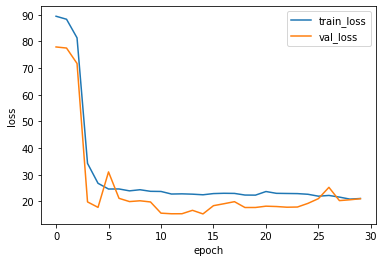

In [ ]:
plt.plot(epoch_count7, train_losses7, label = 'train_loss')
plt.plot(epoch_count7, val_losses7, label = 'val_loss')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

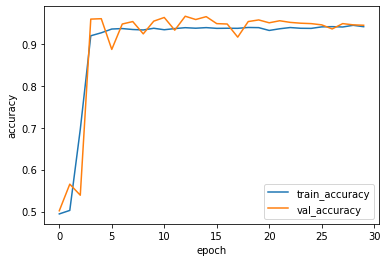

In [ ]:
plt.plot(epoch_count7, train_acc7, label = 'train_accuracy')
plt.plot(epoch_count7, val_acc7, label = 'val_accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('accuracy')

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/model_11weight_trial7_lostfunction.pt'))

<All keys matched successfully>

Normalized confusion matrix
[[0.87777778 0.12222222]
 [0.00444444 0.99555556]]


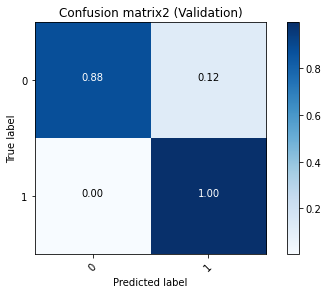

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valloader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')

Normalized confusion matrix
[[0.88313725 0.11686275]
 [0.01333333 0.98666667]]


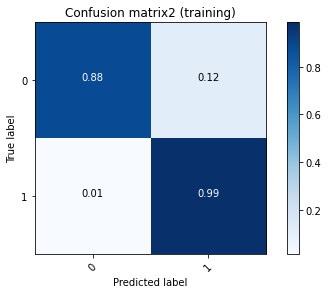

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in trainloader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (training)')

Normalized confusion matrix
[[0.87777778 0.12222222]
 [0.         1.        ]]


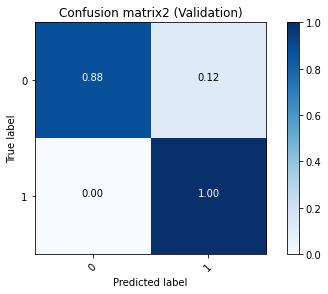

In [ ]:
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valtest_loader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')

### Trail 5 - weighted cross-entropy (823:1) + dynamic training data refreshed every 5 epochs

In [ ]:
#from torch.optim import Adam
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0005) # weight_decay = 0.005

# defining the loss function

weight = torch.tensor([823., 1.])
criterion = nn.CrossEntropyLoss(weight=weight)

In [ ]:
model.apply(weight_reset)

Net(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (9): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=2048, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_

In [ ]:
# defining the number of epochs
n_epochs = 80
# empty list to store training losses
train_losses9 = []
train_acc9 = []
# empty list to store validation losses
val_losses9 = []
val_acc9 =[]
epoch_count9 = []
# training the model
es = 0
best_loss = 1000
for epoch in range(n_epochs):
    if epoch % 5 != 0:
      pass
    else:
      all_train, all_val = dynamic_train_val_split(val_perc = 0.15, seed = epoch)
      trainloader, valloader = dataloader_builder(all_train, all_val, max_side = 24, grid = 2)

    train(epoch, trainloader = trainloader, valloader = valloader)
    epoch_count9.append(epoch)
    train_losses9.append(train.train_loss/len(trainloader))
    val_losses9.append(train.val_loss/len(valloader))
    train_acc9.append(train.train_acces/len(trainloader))
    val_acc9.append(train.val_acces/len(valloader))
    # early stopping
    if train.val_loss/len(valloader) < best_loss:
      best_loss = train.val_loss/len(valloader)
      es = 0
      torch.save(model.state_dict(), "model_" + str(epoch) + 'weight_trial9.pt')
      best_epoch = epoch
    else:
      es += 1
      print("Counter {} of 15".format(es))

    if es > 14:
      print("Early stopping! Best epoch: ", str(best_epoch))
      model.load_state_dict(torch.load('/content/model_' + str(best_epoch) +'weight_trial9.pt'))
      break

Positive cases in training:  2548 Negative cases in training:  2552
Positive cases in val:  450 Negative cases in training:  450
24 2
(5100, 1, 25, 25, 25)
25.0
(900, 1, 25, 25, 25)
Epoch 1 - Training loss: 5.495101535040885, Training Accuracy: 0.5023075342178345
Validation loss: 1.7548201971076196, Validation Accuracy: 0.560546875
Epoch 2 - Training loss: 1.5971425311639904, Training Accuracy: 0.4993561804294586
Validation loss: 1.2227823305875063, Validation Accuracy: 0.4697265625
Epoch 3 - Training loss: 1.3845733338035644, Training Accuracy: 0.49964556097984314
Validation loss: 1.145823580212891, Validation Accuracy: 0.5
Epoch 4 - Training loss: 1.304803282674402, Training Accuracy: 0.4995731711387634
Validation loss: 1.1026128213852644, Validation Accuracy: 0.4697265625
Epoch 5 - Training loss: 1.2546565631404518, Training Accuracy: 0.4997178912162781
Validation loss: 1.0981388785876334, Validation Accuracy: 0.5
Positive cases in training:  2548 Negative cases in training:  2552
P

Text(0, 0.5, 'loss')

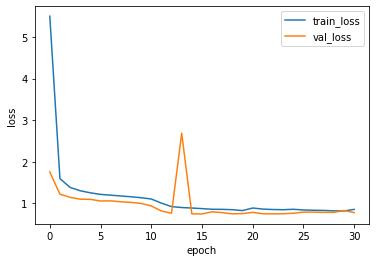

In [ ]:
plt.plot(epoch_count9, train_losses9, label = 'train_loss')
plt.plot(epoch_count9, val_losses9, label = 'val_loss')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

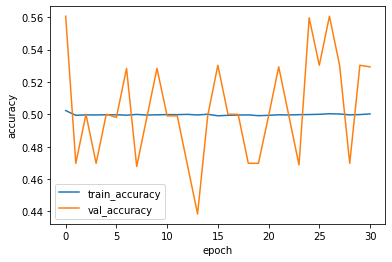

In [ ]:
plt.plot(epoch_count9, train_acc9, label = 'train_accuracy')
plt.plot(epoch_count9, val_acc9, label = 'val_accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('accuracy')

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


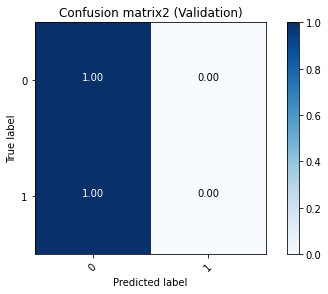

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valloader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


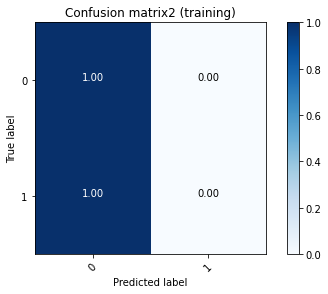

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in trainloader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (training)')

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


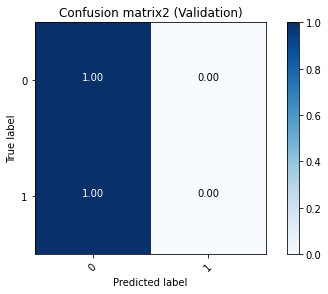

In [ ]:
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valtest_loader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')

### Trail 6 - weighted cross-entropy (200:1) + dynamic training data refreshed every 5 epochs

In [ ]:
#from torch.optim import Adam
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0005) # weight_decay = 0.005

#weight = torch.tensor([200, 1.])
weight = torch.tensor([ 1., 200])
criterion = nn.CrossEntropyLoss(weight=weight)

In [ ]:
model.apply(weight_reset)

Net(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (9): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=2048, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_

In [ ]:
# defining the number of epochs
n_epochs = 80
# empty list to store training losses
train_losses10 = []
train_acc10 = []
# empty list to store validation losses
val_losses10 = []
val_acc10 =[]
epoch_count10 = []
# training the model
es = 0
best_loss = 1000
for epoch in range(n_epochs):
    if epoch % 5 != 0:
      pass
    else:
      all_train, all_val = dynamic_train_val_split(val_perc = 0.15, seed = epoch)
      trainloader, valloader = dataloader_builder(all_train, all_val, max_side = 24, grid = 2)

    train(epoch, trainloader = trainloader, valloader = valloader)
    epoch_count10.append(epoch)
    train_losses10.append(train.train_loss/len(trainloader))
    val_losses10.append(train.val_loss/len(valloader))
    train_acc10.append(train.train_acces/len(trainloader))
    val_acc10.append(train.val_acces/len(valloader))
    # early stopping
    if train.val_loss/len(valloader) < best_loss:
      best_loss = train.val_loss/len(valloader)
      es = 0
      torch.save(model.state_dict(), "model_" + str(epoch) + 'weight_trial10.pt')
      best_epoch = epoch
    else:
      es += 1
      print("Counter {} of 15".format(es))

    if es > 14:
      print("Early stopping! Best epoch: ", str(best_epoch))
      model.load_state_dict(torch.load('/content/model_' + str(best_epoch) +'weight_trial10.pt'))
      break

Positive cases in training:  2548 Negative cases in training:  2552
Positive cases in val:  450 Negative cases in training:  450
24 2


KeyboardInterrupt: ignored

Text(0, 0.5, 'loss')

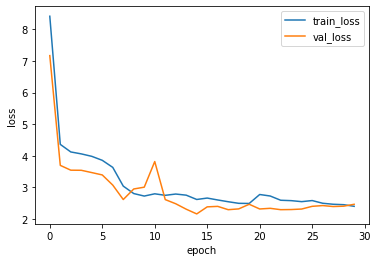

In [ ]:
plt.plot(epoch_count10, train_losses10, label = 'train_loss')
plt.plot(epoch_count10, val_losses10, label = 'val_loss')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

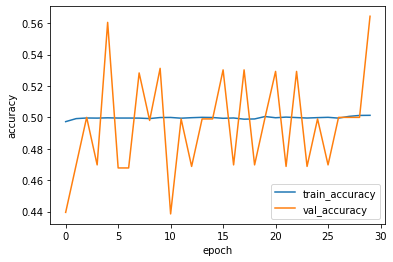

In [ ]:
plt.plot(epoch_count10, train_acc10, label = 'train_accuracy')
plt.plot(epoch_count10, val_acc10, label = 'val_accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('accuracy')

Normalized confusion matrix
[[0.97555556 0.02444444]
 [0.98222222 0.01777778]]


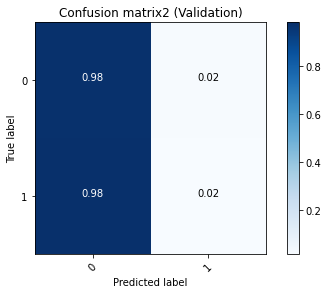

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valloader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')

Normalized confusion matrix
[[0.97137255 0.02862745]
 [0.97333333 0.02666667]]


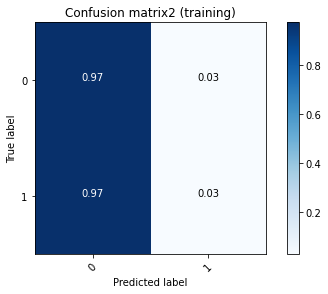

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in trainloader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (training)')

Normalized confusion matrix
[[0.97555556 0.02444444]
 [0.97777778 0.02222222]]


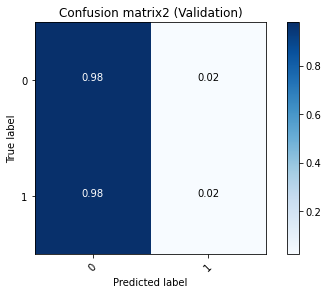

In [ ]:
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valtest_loader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')

### Trail 7 - weighted cross-entropy (1:200) + dynamic training data refreshed every 5 epochs

In [ ]:
#from torch.optim import Adam
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0005) # weight_decay = 0.005

#weight = torch.tensor([200, 1.])
weight = torch.tensor([ 1., 200])
criterion = nn.CrossEntropyLoss(weight=weight)

In [ ]:
model.apply(weight_reset)

Net(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (9): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=2048, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_

In [ ]:
# defining the number of epochs
n_epochs = 80
# empty list to store training losses
train_losses10 = []
train_acc10 = []
# empty list to store validation losses
val_losses10 = []
val_acc10 =[]
epoch_count10 = []
# training the model
es = 0
best_loss = 1000
for epoch in range(n_epochs):
    if epoch % 5 != 0:
      pass
    else:
      all_train, all_val = dynamic_train_val_split(val_perc = 0.15, seed = epoch)
      trainloader, valloader = dataloader_builder(all_train, all_val, max_side = 24, grid = 2)

    train(epoch, trainloader = trainloader, valloader = valloader)
    epoch_count10.append(epoch)
    train_losses10.append(train.train_loss/len(trainloader))
    val_losses10.append(train.val_loss/len(valloader))
    train_acc10.append(train.train_acces/len(trainloader))
    val_acc10.append(train.val_acces/len(valloader))
    # early stopping
    if train.val_loss/len(valloader) < best_loss:
      best_loss = train.val_loss/len(valloader)
      es = 0
      torch.save(model.state_dict(), "model_" + str(epoch) + 'weight_trial10.pt')
      best_epoch = epoch
    else:
      es += 1
      print("Counter {} of 15".format(es))

    if es > 14:
      print("Early stopping! Best epoch: ", str(best_epoch))
      model.load_state_dict(torch.load('/content/model_' + str(best_epoch) +'weight_trial10.pt'))
      break

Positive cases in training:  2548 Negative cases in training:  2552
Positive cases in val:  450 Negative cases in training:  450
24 2
(5100, 1, 25, 25, 25)
25.0
(900, 1, 25, 25, 25)
Epoch 1 - Training loss: 10.457362024486065, Training Accuracy: 0.4992549419403076
Validation loss: 4.446492113173008, Validation Accuracy: 0.4697265625
Epoch 2 - Training loss: 4.328126550838351, Training Accuracy: 0.5001012682914734
Validation loss: 3.597989071160555, Validation Accuracy: 0.5
Epoch 3 - Training loss: 4.059100974909962, Training Accuracy: 0.5006438493728638
Validation loss: 3.5044614151120186, Validation Accuracy: 0.5302734375
Epoch 4 - Training loss: 3.949259652942419, Training Accuracy: 0.5003544092178345
Validation loss: 3.434569103643298, Validation Accuracy: 0.5
Epoch 5 - Training loss: 3.6229697465896606, Training Accuracy: 0.5004268288612366
Validation loss: 3.026004084851593, Validation Accuracy: 0.5302734375
Positive cases in training:  2548 Negative cases in training:  2552
Posit

Text(0, 0.5, 'loss')

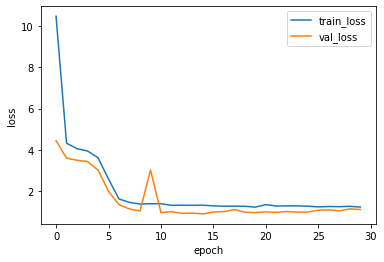

In [ ]:
plt.plot(epoch_count10, train_losses10, label = 'train_loss')
plt.plot(epoch_count10, val_losses10, label = 'val_loss')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

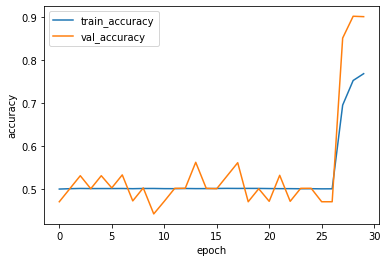

In [ ]:
plt.plot(epoch_count10, train_acc10, label = 'train_accuracy')
plt.plot(epoch_count10, val_acc10, label = 'val_accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('accuracy')

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


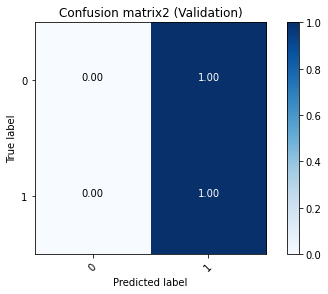

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valloader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


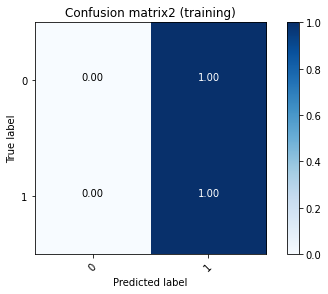

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in trainloader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (training)')

Normalized confusion matrix
[[0.97555556 0.02444444]
 [0.97777778 0.02222222]]


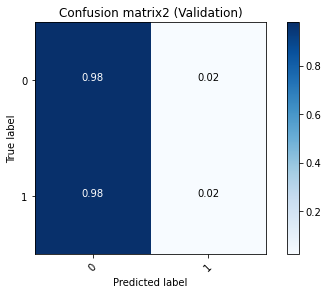

In [ ]:
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valtest_loader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')